In [ ]:
!python -m pip install tslearn

In [ ]:
%pip install h5py

In [58]:
from utilities import get_path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta, datetime, date
from tslearn.clustering import TimeSeriesKMeans
from tslearn.generators import random_walks
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import zlib
from tslearn.piecewise import PiecewiseAggregateApproximation

In [32]:
DATA_PATH = get_path()

In [33]:
df_tweets = pd.read_csv(DATA_PATH+'tweets_clean.csv', sep='#')
df_users = pd.read_csv(DATA_PATH+'users_clean.csv', sep='#')

OSError: [Errno 22] Invalid argument

In [286]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10187873 entries, 0 to 10187872
Data columns (total 10 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   user_id                   object
 1   publication_date          object
 2   text                      object
 3   publication_date_in_secs  int64 
 4   retweet_count             int64 
 5   reply_count               int64 
 6   favorite_count            int64 
 7   num_hashtags              int64 
 8   num_urls                  int64 
 9   num_mentions              int64 
dtypes: int64(7), object(3)
memory usage: 777.3+ MB


In [287]:
start_2019 = pd.to_datetime(["20190101"]).astype(np.int64)[0]
end_2019 = pd.to_datetime(["20191231"]).astype(np.int64)[0]
df_tweets2019 = df_tweets[(df_tweets['publication_date_in_secs'] >= start_2019) & (df_tweets['publication_date_in_secs'] <= end_2019)]

In [288]:
df_users.id = df_users.id.astype(str)
df_merged = df_tweets2019.merge(df_users, left_on='user_id', right_on='id', how='right')

In [289]:
df_merged['publication_date_in_secs'].shape

(4514310,)

In [290]:
df_merged.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4514310 entries, 0 to 4514309
Data columns (total 17 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   user_id                    4509589 non-null  object 
 1   publication_date           4509589 non-null  object 
 2   text                       4411353 non-null  object 
 3   publication_date_in_secs   4509589 non-null  float64
 4   retweet_count              4509589 non-null  float64
 5   reply_count                4509589 non-null  float64
 6   favorite_count             4509589 non-null  float64
 7   num_hashtags               4509589 non-null  float64
 8   num_urls                   4509589 non-null  float64
 9   num_mentions               4509589 non-null  float64
 10  id                         4514310 non-null  object 
 11  name                       4514309 non-null  object 
 12  lang                       4514310 non-null  object 
 13  bot         

In [291]:
df_merged.user_id.fillna(-1, inplace=True)
users_list = df_merged.user_id.unique()
users_list = users_list.tolist()
users_list.remove(-1)

In [293]:
len(users_list)

6787

In [294]:
#For each user save the timeseries of pubblications
ts_pubblications = {}
df_grouped = df_merged.groupby(by=['user_id'])
for user in users_list:
    ts_pubblications[user] = df_grouped.get_group(str(user)).publication_date_in_secs.tolist()

In [295]:
# Cast publication date into date format
df_merged['publication_date'] = pd.to_datetime(df_merged.publication_date)
df_merged['publication_date'] = df_merged['publication_date'].dt.date

In [296]:
df_merged.user_id.fillna(-1, inplace=True)

In [297]:
df_merged

,user_id,publication_date,text,publication_date_in_secs,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,id,name,lang,bot,user_subscription,statuses_count,user_subscription_in_secs
0,2353593986,2019-07-11,"@4fri2endly0 ""A business that makes nothing bu...",1.562817e+18,0.0,0.0,0.0,0.0,0.0,1.0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76.0,1550858442000000000
1,2353593986,2019-06-21,"""Happiness is not a station you arrive at, but...",1.561104e+18,0.0,0.0,0.0,0.0,0.0,0.0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76.0,1550858442000000000
2,2353593986,2019-04-05,Music flow.,1.554468e+18,0.0,0.0,0.0,0.0,0.0,0.0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76.0,1550858442000000000
3,2353593986,2019-07-25,@_SimplyKC follow meeee...,1.564057e+18,0.0,0.0,0.0,0.0,0.0,1.0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76.0,1550858442000000000
4,2353593986,2019-04-29,"""You are the only person on earth who can use ...",1.556571e+18,0.0,0.0,0.0,0.0,0.0,0.0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76.0,1550858442000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4514305,2383025796,2019-04-28,make up money could be going to so many other ...,1.556465e+18,0.0,0.0,0.0,0.0,0.0,0.0,2383025796,Minnie Guadagno,en,1,2019-03-13 02:44:13,42.0,1552445053000000000
4514306,2383025796,2019-05-02,@dilligaf_life !,1.556808e+18,0.0,0.0,1.0,0.0,0.0,1.0,2383025796,Minnie Guadagno,en,1,2019-03-13 02:44:13,42.0,1552445053000000000
4514307,2383025796,2019-04-27,I Thank God Everyday. I Know Where I Could've ...,1.556358e+18,0.0,0.0,0.0,0.0,0.0,0.0,2383025796,Minnie Guadagno,en,1,2019-03-13 02:44:13,42.0,1552445053000000000
4514308,2383025796,2019-04-29,@itsJAYJAYbruh nice...,1.556534e+18,0.0,0.0,1.0,0.0,0.0,1.0,2383025796,Minnie Guadagno,en,1,2019-03-13 02:44:13,42.0,1552445053000000000


In [369]:
def extract_daily_scores(df):

    day = date(2019,1,1)
    end = date(2019,12,31)

    success_scores = []

    df = df.groupby(by=['publication_date'])
    
    while day <= end:
        try:
            group = df.get_group(day)
            acceptance_score = group['retweet_count'].sum() + group['reply_count'].sum() + group['favorite_count'].sum()
            diffusion_score = group['num_hashtags'].sum() + group['num_mentions'].sum() + group['num_urls'].sum()
            success_scores.append(acceptance_score / (diffusion_score + 0.1))
        except KeyError:
            success_scores.append(-1)

        day = day + timedelta(days=1)

    return success_scores
        

In [370]:
def extract_users_scores(df):

    df_grouped_pub_day = df.groupby(by=['user_id'])
    users_scores = {}
    
    # Extract for each user a timeseries of daily scores about tweets of 2019
    for user in users_list:
        user_group = df_grouped_pub_day.get_group(str(user))
        users_scores[user] = extract_daily_scores(user_group)
    
    return users_scores


In [371]:
res = extract_users_scores(df_merged)

In [372]:
df_timeseries = pd.DataFrame(res.items())

In [373]:
df_timeseries.head()

,0,1
0,2353593986,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
1,2358850842,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
2,466124818,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
3,2199062688,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
4,2357425536,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."


In [374]:
df_timeseries['publications'] = df_timeseries[0].map(ts_pubblications)

In [375]:
df_timeseries.head()

,0,1,publications
0,2353593986,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[1.562816946e+18, 1.561104313e+18, 1.55446806e..."
1,2358850842,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[1.563961546e+18, 1.556421671e+18, 1.556749642..."
2,466124818,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[1.571747079e+18, 1.562044389e+18, 1.567421266..."
3,2199062688,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[1.564036843e+18, 1.561534888e+18, 1.561055373..."
4,2357425536,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[1.563345763e+18, 1.554433812e+18, 1.562575589..."


In [376]:
df_timeseries.rename(columns={0: 'user_id', 1: 'success_scores'}, inplace=True)

In [377]:
df_timeseries.head()

,user_id,success_scores,publications
0,2353593986,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[1.562816946e+18, 1.561104313e+18, 1.55446806e..."
1,2358850842,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[1.563961546e+18, 1.556421671e+18, 1.556749642..."
2,466124818,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[1.571747079e+18, 1.562044389e+18, 1.567421266..."
3,2199062688,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[1.564036843e+18, 1.561534888e+18, 1.561055373..."
4,2357425536,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[1.563345763e+18, 1.554433812e+18, 1.562575589..."


In [378]:
df_timeseries.to_csv(path_or_buf=DATA_PATH+'tweets_timeseries.csv', sep='#', index=False)

In [4]:
df_timeseries = pd.read_csv(DATA_PATH+'tweets_timeseries.csv', sep='#')

In [5]:
ts_list = df_timeseries.success_scores.values

In [6]:
#Cast timeseries from string to list
timeseries_list = []
for i, item in enumerate(ts_list):
    timeseries_list.append(eval(item))
    timeseries_list[i] = np.array(timeseries_list[i], dtype=object)

In [7]:
#Reshape timeseries as numpy array and numpy matrix
timeseries_list = np.array(timeseries_list, dtype=object)
timeseries_matrix = np.asmatrix(timeseries_list)
timeseries_matrix.shape

(6787, 365)

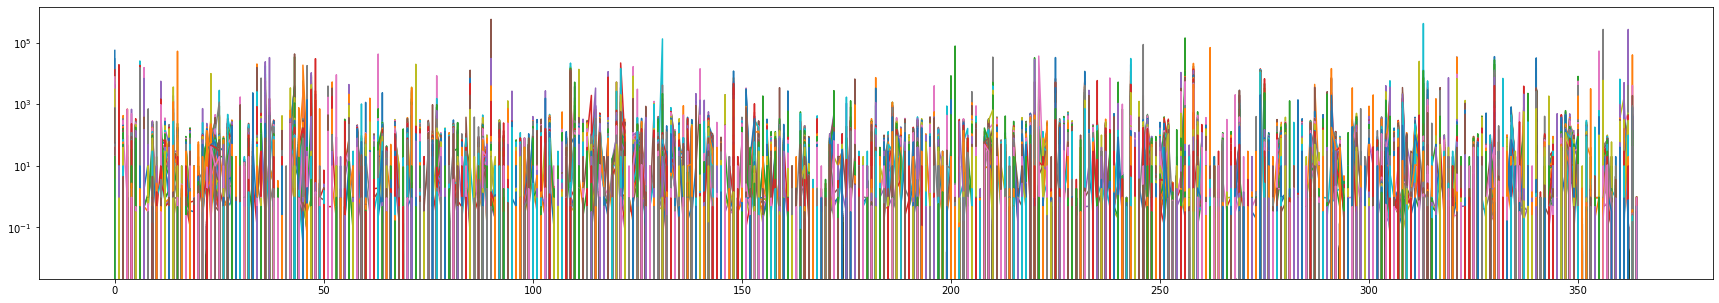

In [8]:
#Plot a direct comparison between all the extracted timeseries
plt.figure(figsize=(30,5))
plt.plot(timeseries_matrix.reshape(timeseries_matrix.shape[1], timeseries_matrix.shape[0]))
plt.yscale('log')
plt.show()

In [85]:
def plot_crosstab(labels, column, legend_labels, xlabel='Cluster', ylabel='bot'):
    # TODO capire perchè non funziona
    bot_ct = pd.crosstab(labels, column)
    fig, ax = plt.subplots(figsize=(24, 8))
    bot_ct.plot(kind='bar', stacked=False, ax=ax)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(prop={'size': 30}, labels=legend_labels)

# Shape-based clustering

In [23]:
#Performs kmeans and plot results
def run_ts_kmeans(data, n_clust, metric, max_iter=100, random_state=42, print=True, log=True):
    
    km = TimeSeriesKMeans(n_clusters=n_clust, metric=metric, max_iter=max_iter, random_state=random_state)
    km.fit(data)
    if print:
        plt.figure(figsize=(30,5))
        plt.title(f'k={n_clust} metric={metric}')
        plt.plot(km.cluster_centers_.reshape(data.shape[1], n_clust))
        if log:
            plt.yscale('log')
        plt.show()

    return km

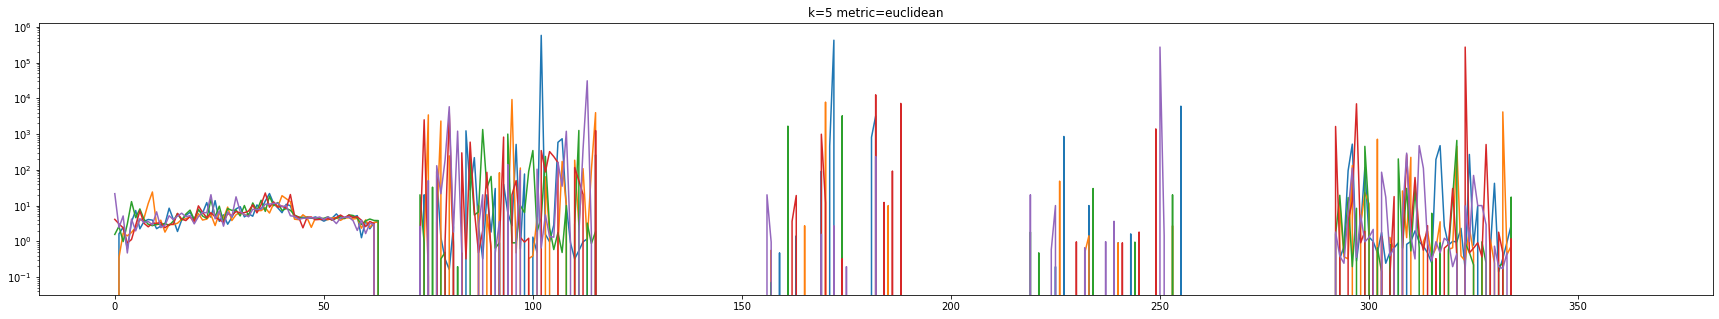

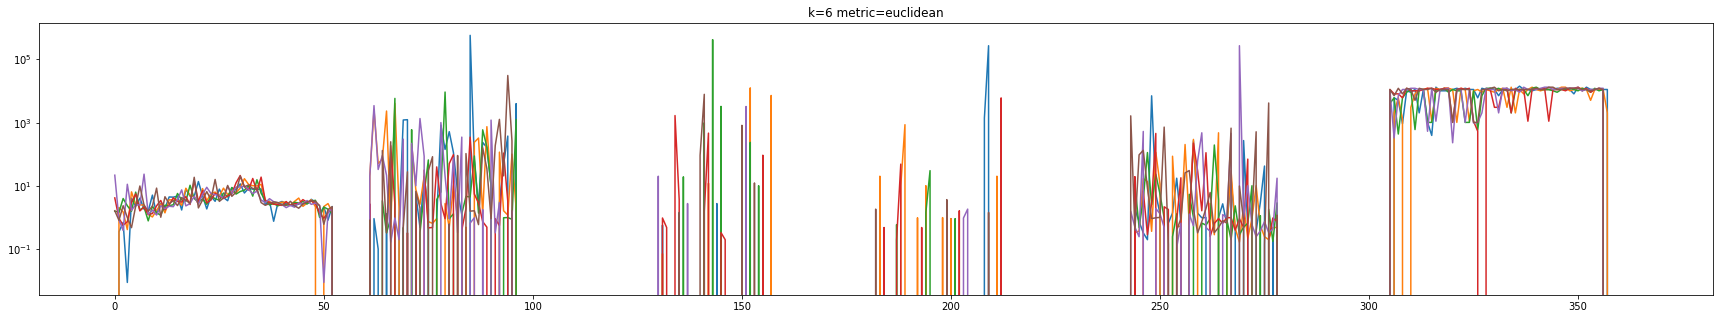

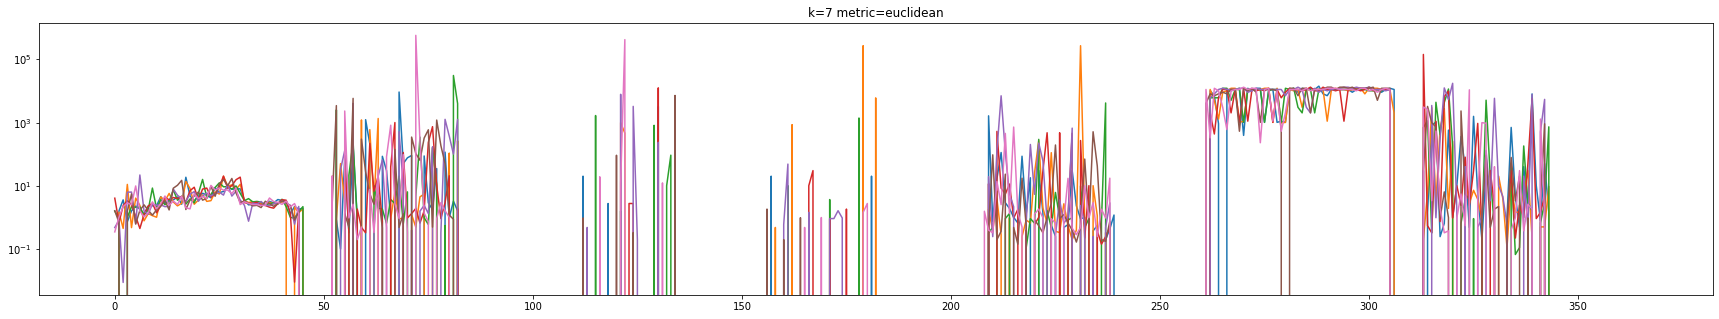

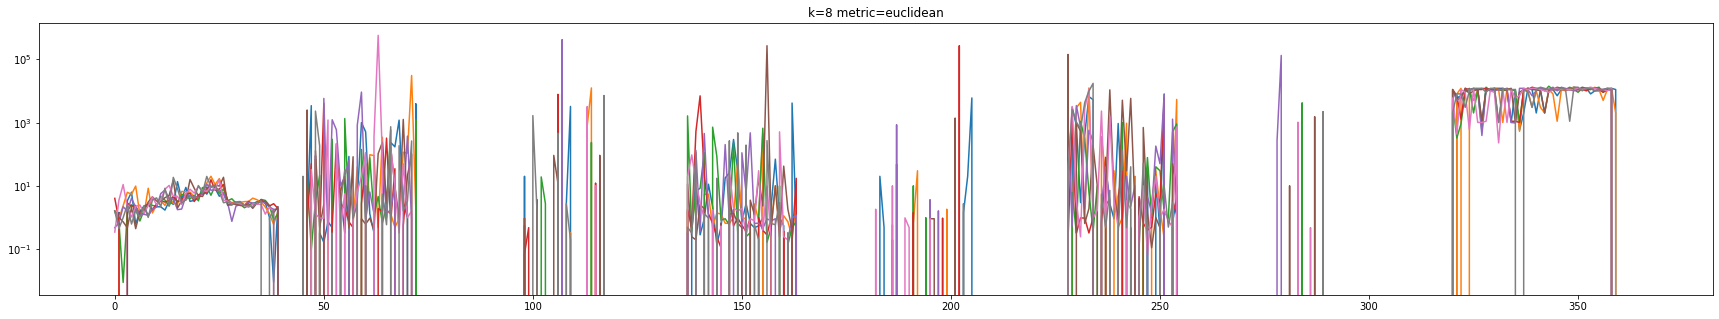

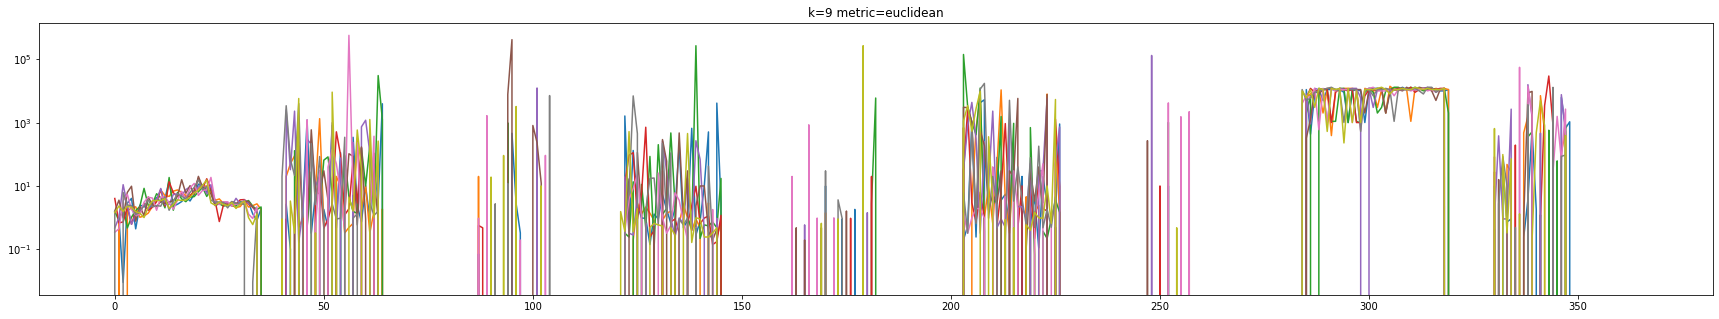

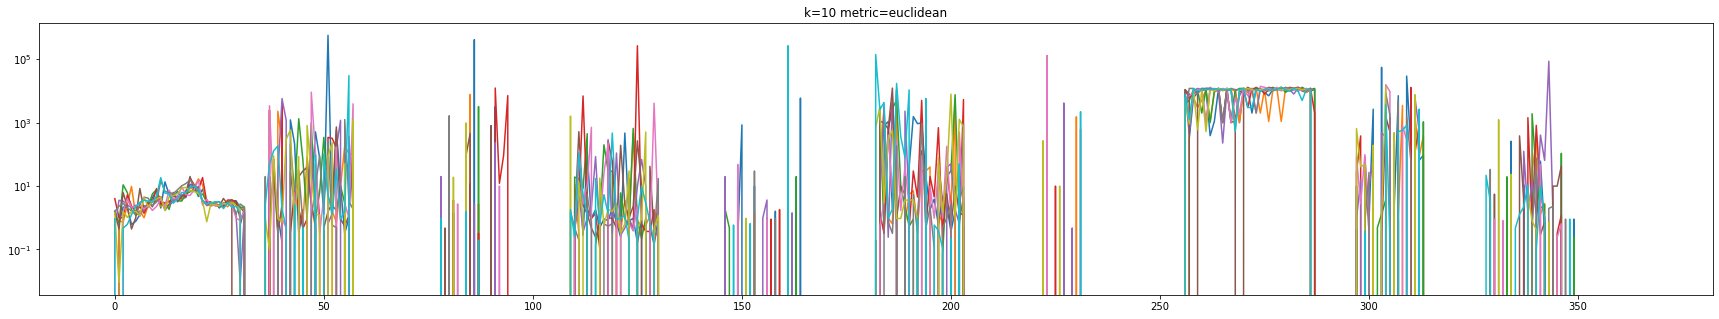

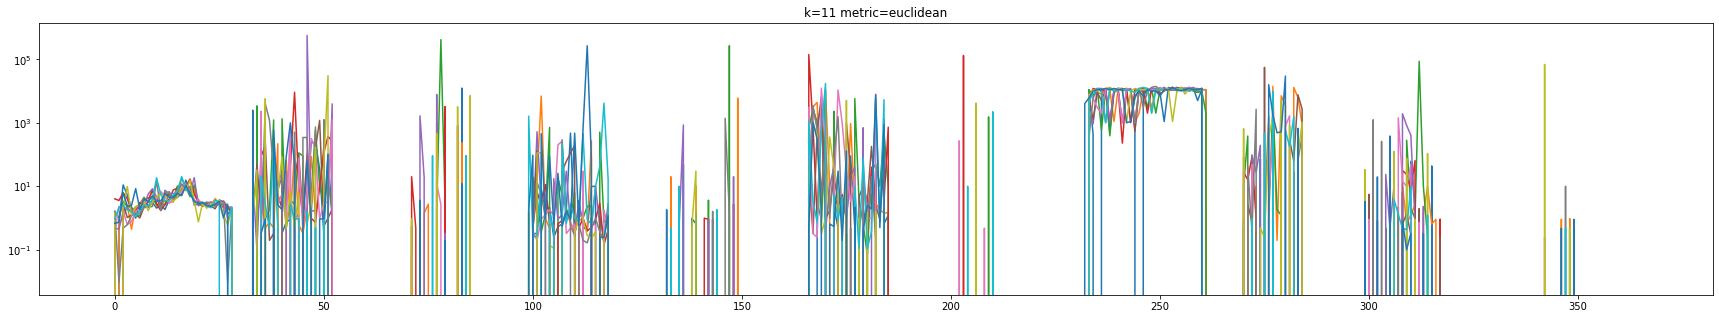

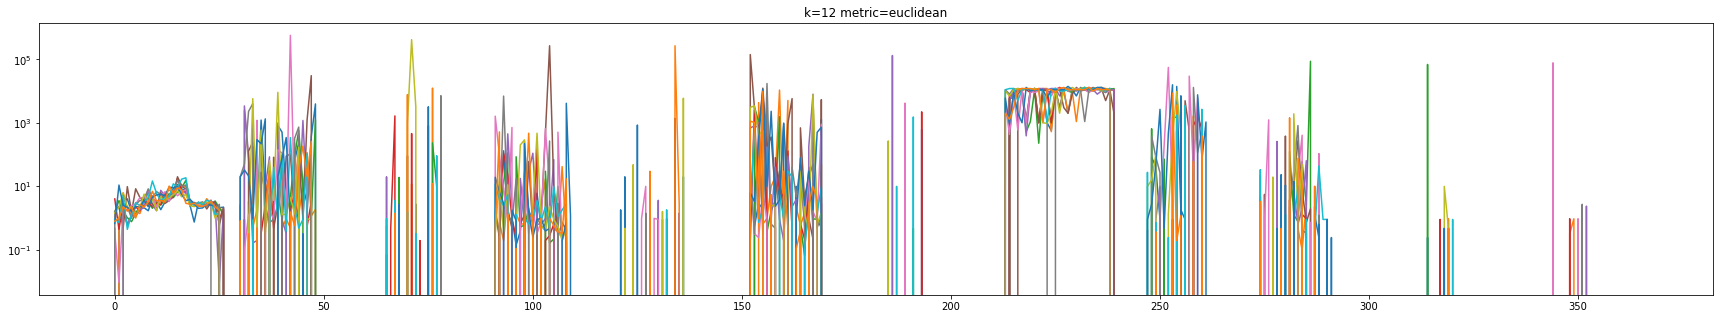

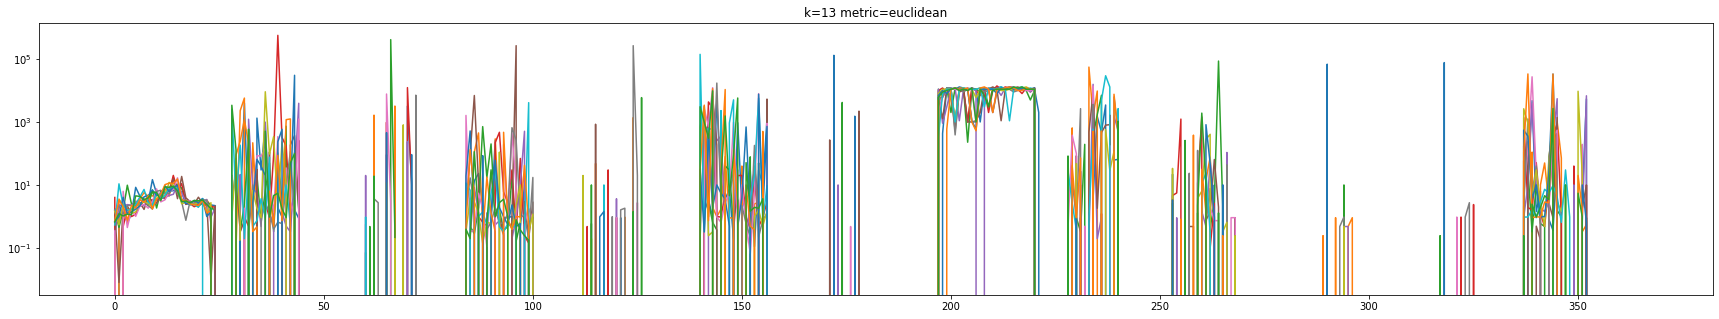

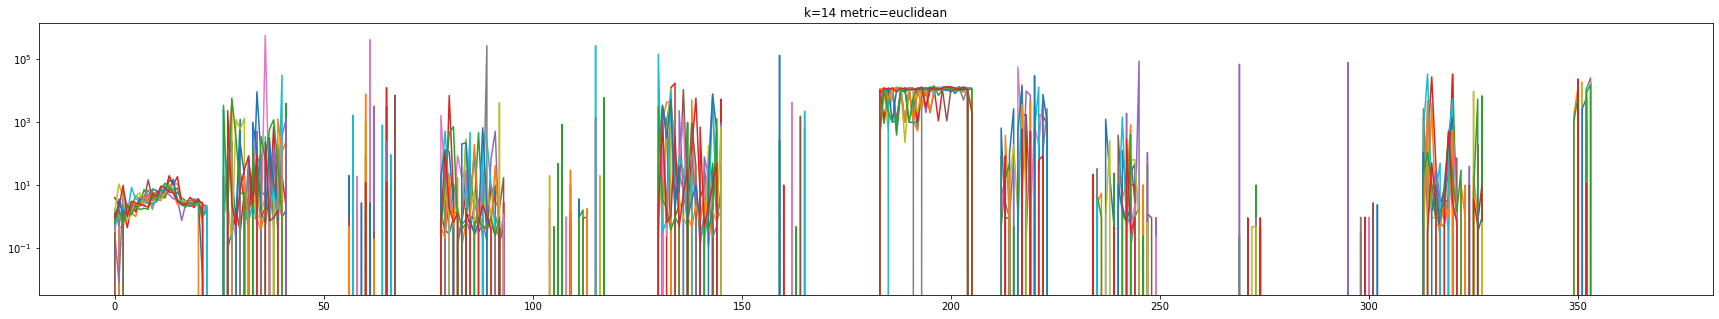

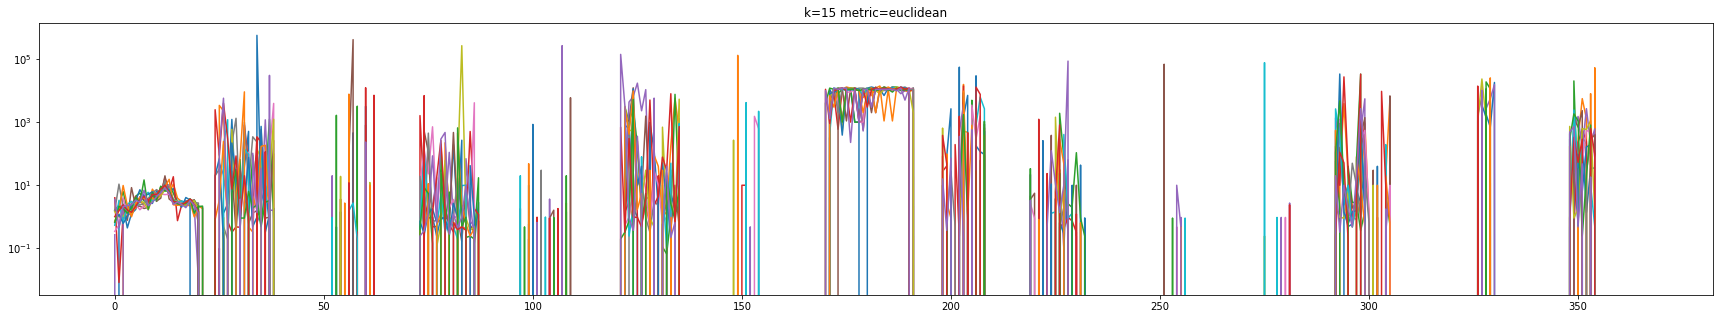

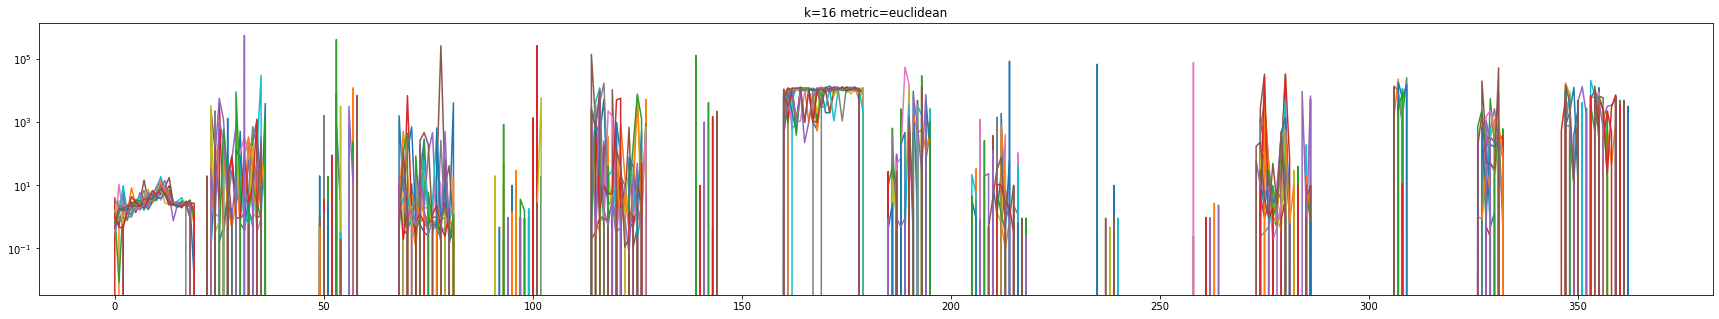

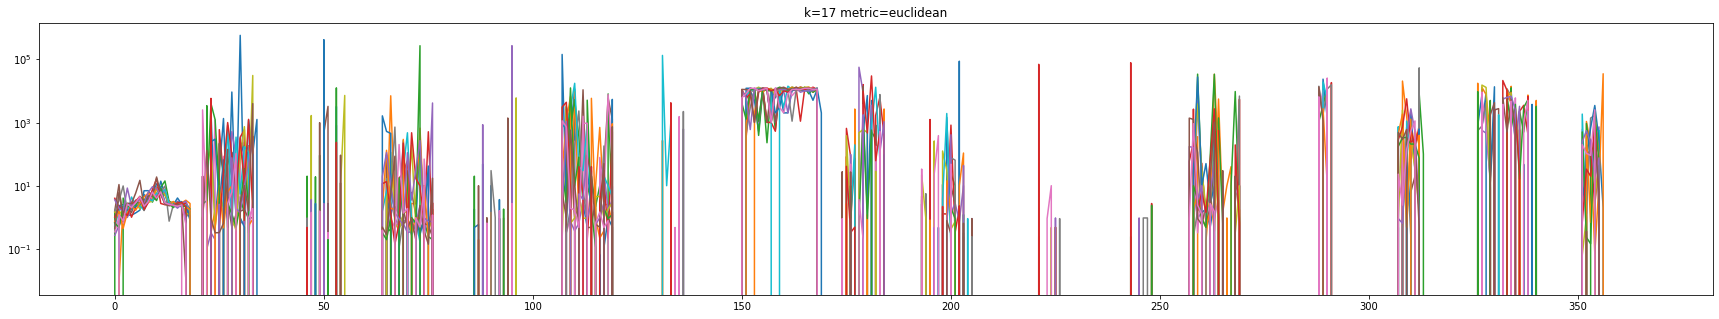

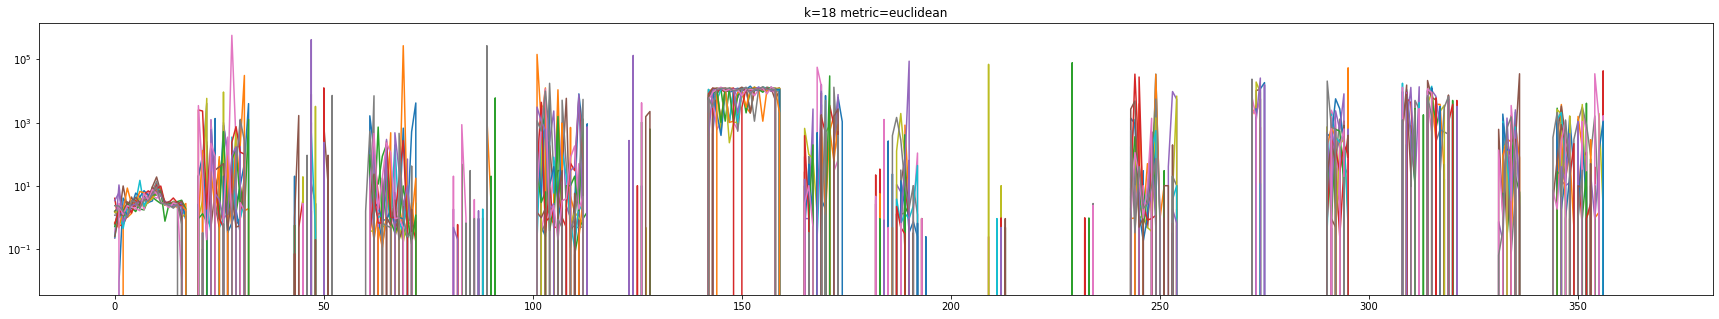

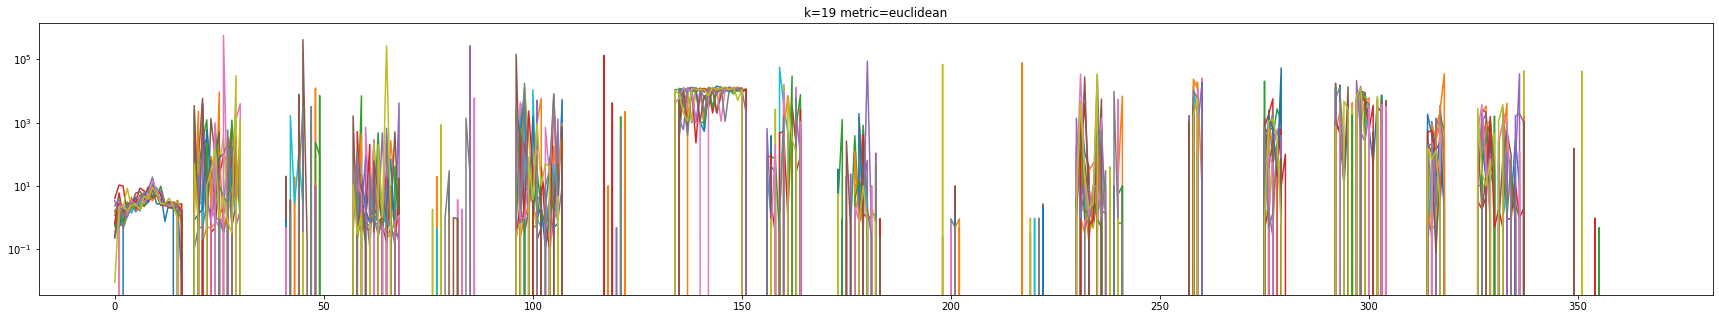

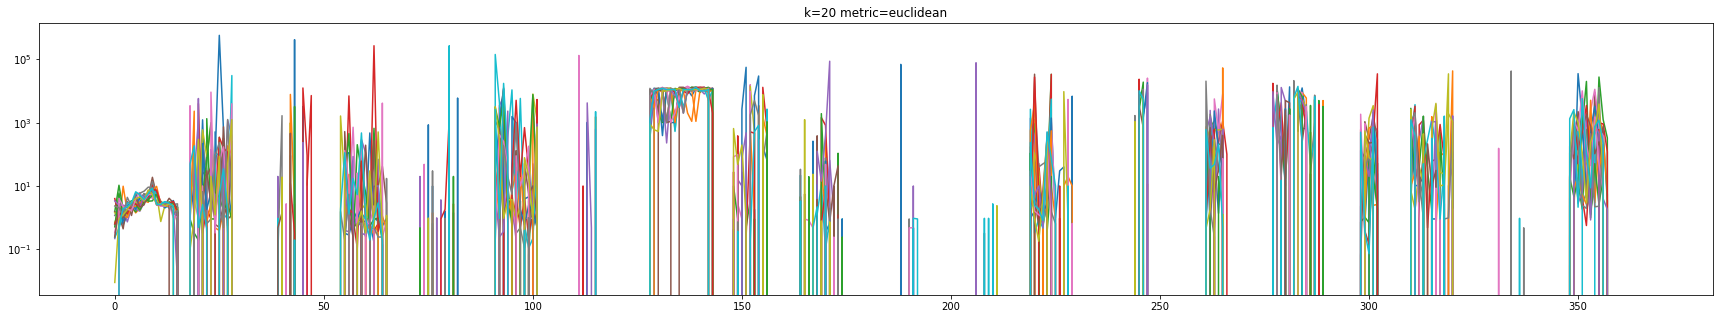

In [27]:
#Make a search for the optimal k
metrics = ["euclidean"]
min_centr = 5
max_centr = 20
sse_list_ts = []
centroids = []
for k in range(min_centr,max_centr+1):
    for metric in metrics:
        kmeans = run_ts_kmeans(timeseries_list, n_clust=k, metric=metric, print=True)
        sse_list_ts.append(kmeans.inertia_)
        centroids.append(kmeans.cluster_centers_)

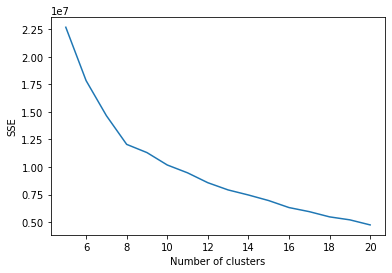

In [28]:
plt.plot(range(min_centr, len(sse_list_ts) + min_centr), sse_list_ts)
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

The best k seems to be 8

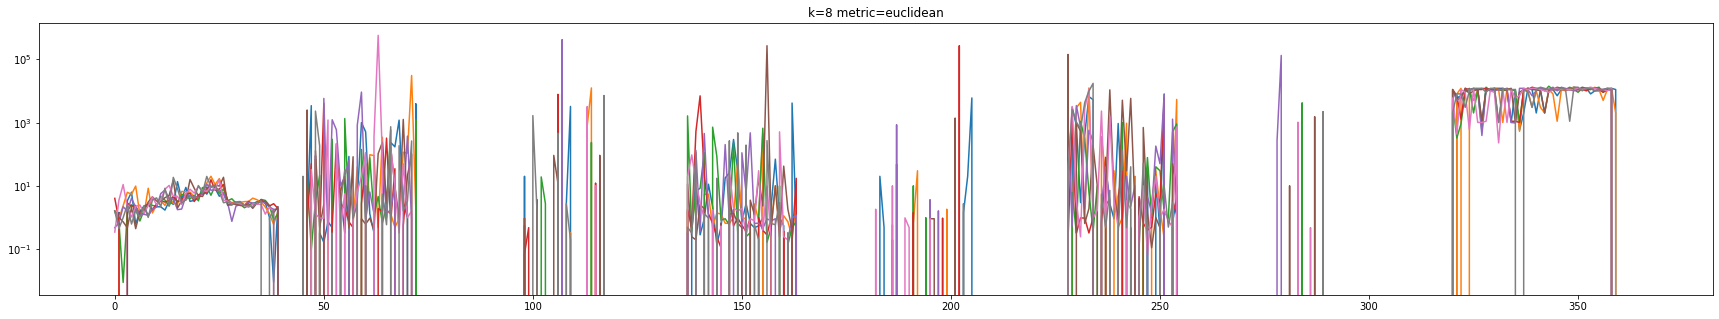

Silouhette score: 0.9934889038047229
Davies Bouldin score: 0.002252526109395566


In [45]:
from clusteringUtilities import get_metrics

kmeans = run_ts_kmeans(timeseries_list, n_clust=8, metric='euclidean')
labels = kmeans.labels_
get_metrics(timeseries_list, kmeans.labels_)

In [35]:
try:
    df_merge = df_timeseries.merge(df_users, left_on='user_id', right_on='id')
except:
    df_users = pd.read_csv(DATA_PATH+'users_clean.csv', sep='#')
    df_merge = df_timeseries.merge(df_users, left_on='user_id', right_on='id')

In [36]:
df_merge.head()

,user_id,success_scores,publications,id,name,lang,bot,user_subscription,statuses_count,user_subscription_in_secs
0,2353593986,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[1.562816946e+18, 1.561104313e+18, 1.55446806e...",2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76.0,1550858442000000000
1,2358850842,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[1.563961546e+18, 1.556421671e+18, 1.556749642...",2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,54.0,1551150152000000000
2,466124818,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[1.571747079e+18, 1.562044389e+18, 1.567421266...",466124818,Carletto Focia,it,1,2017-01-18 02:49:18,50.0,1484707758000000000
3,2199062688,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[1.564036843e+18, 1.561534888e+18, 1.561055373...",2199062688,Qq,en,0,2018-11-19 06:58:18,7406.0,1542610698000000000
4,2357425536,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[1.563345763e+18, 1.554433812e+18, 1.562575589...",2357425536,Meda Tatlock,en,1,2019-02-25 04:30:56,69.0,1551069056000000000


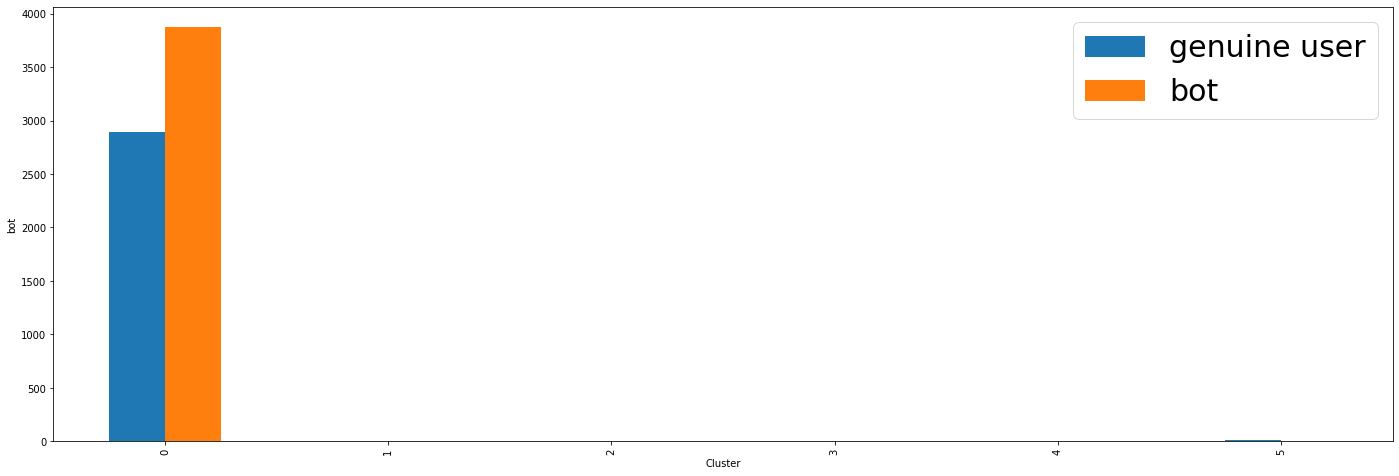

In [86]:
plot_crosstab(labels, df_merge.bot, ['genuine user', 'bot'])

# Feature-based clustering

In [73]:
def extract_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

In [74]:
ts_features = []
for ts in timeseries_list:
    # Cast all elements from obj to int
    ts_int = np.array([int(elem) for elem in ts])
    ts_features.append(list(extract_features(ts_int).values())[:-2])

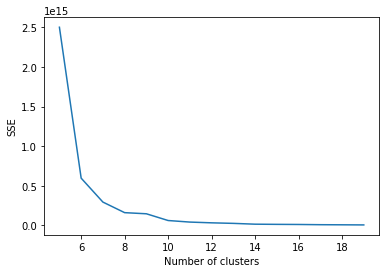

In [77]:
sse_list = []
min_centr=5
max_centr=20
for i in range(min_centr,max_centr):
    kmeans = KMeans(n_clusters=i, n_init='auto')
    kmeans.fit(ts_features)
    sse_list.append(kmeans.inertia_)

plt.plot(range(min_centr, len(sse_list) + min_centr), sse_list)
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In this case the optimal k seems to be 6

In [82]:
kmeans = KMeans(n_clusters=6, n_init='auto')
kmeans.fit(ts_features)
labels = kmeans.labels_

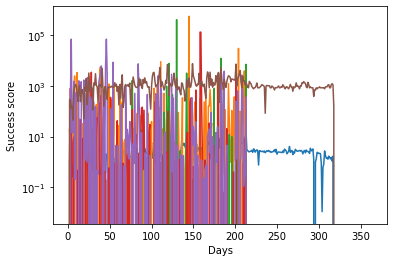

In [90]:
for i in range(6):
    plt.plot(np.mean(timeseries_list[np.where(kmeans.labels_ == i)[0]], axis=0))

plt.ylabel('Success score')
plt.xlabel('Days')
plt.yscale('log')
plt.show()

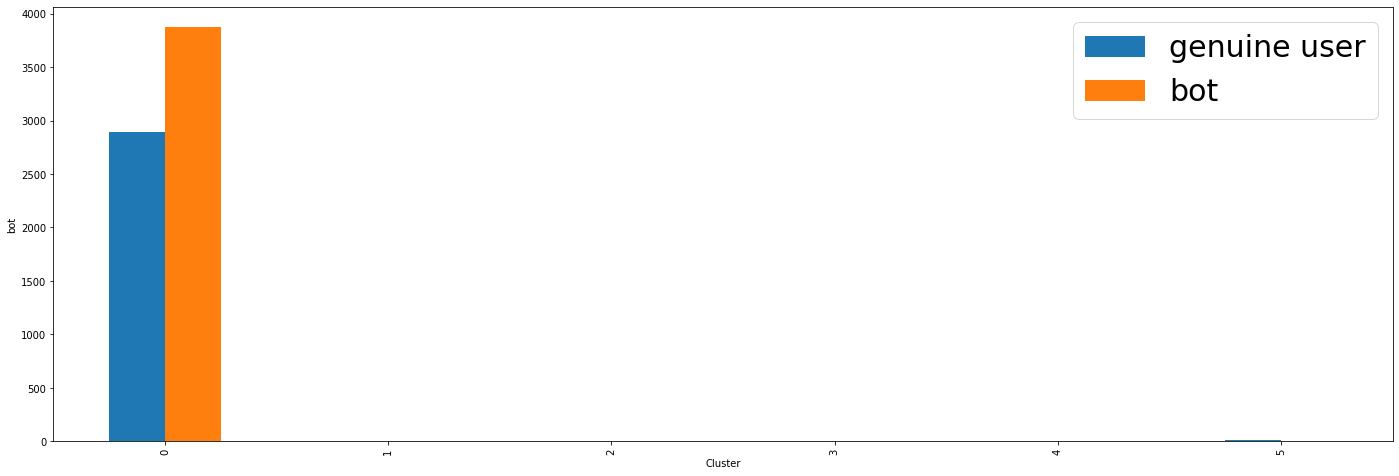

In [87]:
plot_crosstab(labels, df_merge.bot, ['genuine user', 'bot'])

# Compression-based clustering

In [91]:
def cdm_dist(x, y):
    x_str = (' '.join([str(v) for v in x.ravel()])).encode('utf-8')
    y_str = (' '.join([str(v) for v in y.ravel()])).encode('utf-8')
    return len(zlib.compress(x_str + y_str)) / (len(zlib.compress(x_str)) + len(zlib.compress(y_str)))

In [93]:
compressed = pairwise_distances(timeseries_list.reshape(timeseries_list.shape[0], timeseries_list.shape[1]), metric=cdm_dist)

In [94]:
import pickle
with open(DATA_PATH+'compressed_ts', 'wb') as handle:
    pickle.dump(compressed, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [96]:
with open(DATA_PATH+'compressed_ts', 'rb') as handle:
    compressed = pickle.load(handle)

In [97]:
# TODO implement grid search for DBSCAN
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.965, min_samples=5, metric='precomputed')
dbscan.fit(compressed)

DBSCAN(eps=0.965, metric='precomputed')

In [99]:
# TODO implement grid search
n_paa_segments = 10
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
ts_paa = paa.fit_transform(timeseries_list)

c:\Users\Alessandro\AppData\Local\Programs\Python\Python39\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


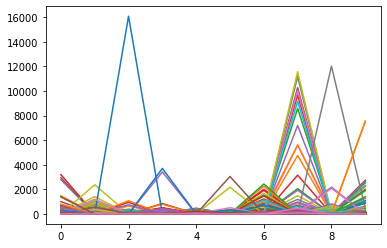

In [100]:
plt.plot(ts_paa.reshape(ts_paa.shape[1], ts_paa.shape[0]))
plt.show()

In [ ]:
# TODO fix runKmeans adding data as parameter and use it also here

# Shapelet

In [ ]:
# TODO create a data structure to handle ts and labels

In [ ]:
plt.figure()
for i, classe in enumerate(['cylinder', 'bell', 'funnel']):
    plt.subplot(3, 1, i + 1)
    for x in X[y == i]:
        plt.plot(x, color='C0', linewidth=0.9)
    plt.title('Class: {}'.format(classe), fontsize=16)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()